In [3]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [4]:
df = pd.read_csv('./Dataset/train7,5k.csv')
df.head()

,class_index,review_text
0,4,well-done film
1,1,characters ramble
2,3,the intensity that made her an interesting cha...
3,1,'s not really funny
4,2,stuffs


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  7500 non-null   int64 
 1   review_text  7500 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.3+ KB


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

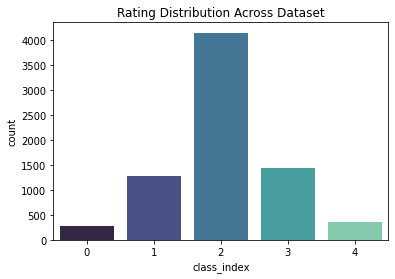

In [6]:
sns.countplot(data=df, x='class_index', palette='mako').set_title('Rating Distribution Across Dataset')

In [7]:
# Length of word in sentence
df['length'] = df['review_text'].apply(len)
df.head()

,class_index,review_text,length
0,4,well-done film,14
1,1,characters ramble,17
2,3,the intensity that made her an interesting cha...,66
3,1,'s not really funny,19
4,2,stuffs,6


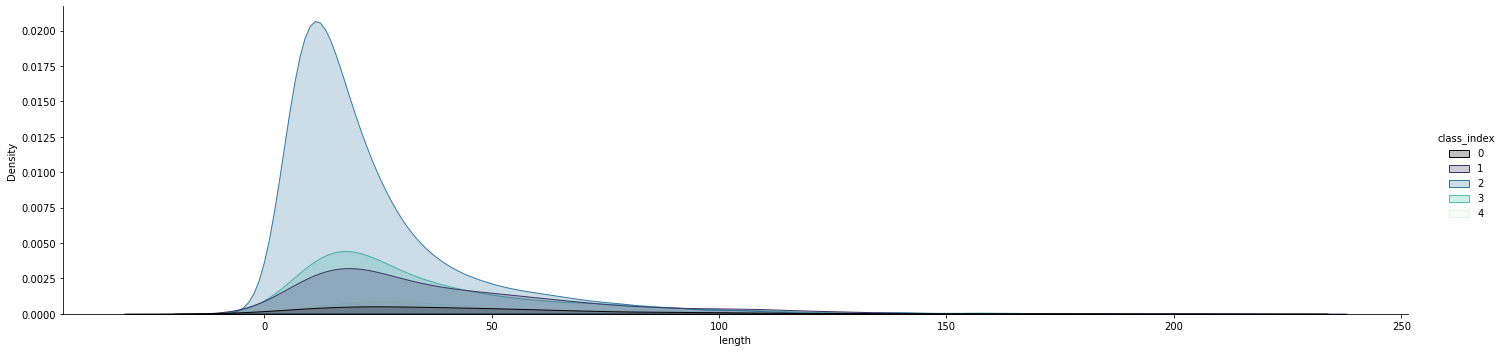

In [8]:
sns.displot(data=df, x='length', hue='class_index', palette='mako', kind='kde', fill=True, aspect=4)

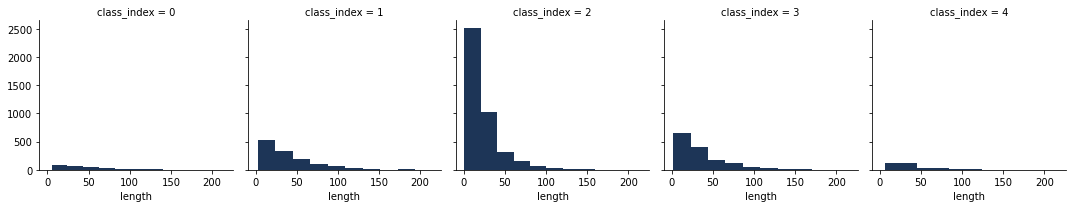

In [9]:
g = sns.FacetGrid(data=df, col='class_index')
g.map(plt.hist, 'length', color='#1D3557')

<AxesSubplot:xlabel='class_index', ylabel='length'>

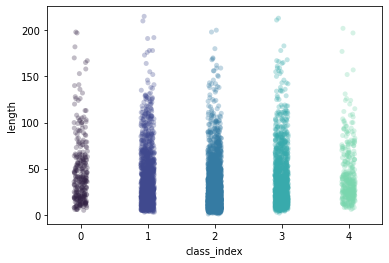

In [10]:
sns.stripplot(data=df, x='class_index', y='length', palette='mako', alpha=0.3)

In [11]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 2:
        return 'Good'
    elif score == 2:
        return 'Netral'
    else:
        return 'Bad'

In [12]:
df['class_index'] = df['class_index'].apply(rating)

In [13]:
df.head()

,class_index,review_text,length
0,Good,well-done film,14
1,Bad,characters ramble,17
2,Good,the intensity that made her an interesting cha...,66
3,Bad,'s not really funny,19
4,Netral,stuffs,6


In [14]:
# Total word in dataset before cleaning
length = df['length'].sum()

In [15]:
print('Original:')
print(df['review_text'][2])
print()

sentence = []
for word in df['review_text'][2].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['review_text'][2].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
the intensity that made her an interesting character to begin with

Stemming:
the intens that made her an interest charact to begin with

Lemmatization:
the intensity that make her an interest character to begin with


In [16]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [17]:
df['review_text'] = df['review_text'].apply(cleaning)

In [18]:
df['length'] = df['review_text'].apply(len)
new_length = df['length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 231112
Total word after cleaning: 160532


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['class_index'], test_size=0.3, random_state=0)

In [20]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [21]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [22]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10), n_jobs=-1).mean()
    accuracy.append(cross_val)

In [23]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.606095
1,RandomForestClassifier,0.632190
2,SVC,0.598286
3,LogisticRegression,0.609524
4,KNeighborsClassifier,0.565333
5,BernoulliNB,0.596381


In [24]:
log = RandomForestClassifier()
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [25]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 160   28  313]
 [  35  199  316]
 [  61   78 1060]]
              precision    recall  f1-score   support

         Bad       0.62      0.32      0.42       501
        Good       0.65      0.36      0.47       550
      Netral       0.63      0.88      0.73      1199

    accuracy                           0.63      2250
   macro avg       0.64      0.52      0.54      2250
weighted avg       0.63      0.63      0.60      2250



In [26]:
# RandomForestClassifier
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]
    
    return pred

In [27]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using RandomForestClassifier: {}'.format(ml_predict(text)))

Prediction using RandomForestClassifier: Good
